# ステップ58 代表的なCNN(VGG16)

前ステップでは、Conv2d レイヤとpooling 関数の実装ができました。ここでは、
それらを使ってVGG16 と呼ばれる有名なモデルを実装してみます。また学習済み
の重みを使って、推論処理を行ってみます。

## 58.1 VGG16の実装

VGG[36] は、2014 年のILSVRC というコンペティションで準優勝したモデルで
す。論文[36] では、モデルで使用するレイヤの数などによっていくつかバリエーショ
ンが提案されています。ここでは、その中の「VGG16」と呼ばれるモデルを実装し
ます。そのネットワーク構成は、図58-1 のようになります。

![58_1](fig/58_1.png)

図58-1 の「3x3 conv 64」とは、カーネルサイズが3 × 3 で、出力のチャンネル
数が64 ということを意味します。また、「pool/2」は2 × 2 のプーリング、「linear
4096」は出力サイズが4096 の全結合層です。このVGG16 の特徴としては、以下の
点が挙げられます。

● 3 × 3 の畳み込み層を使う（パディングは1 × 1）<br>
● 畳み込み層のチャンネル数は、（基本的には）プーリングを行うと2 倍になる
（64 → 128 → 256 → 512）<br>
● 全結合層ではDropout を使う<br>
● 活性化関数はReLU を使う

それでは、図58-1 を参考にして、VGG16 を実装します。そのコードは次のよう
になります。

``` python
import dezero.functions as F
import dezero.layers as

class VGG16(Model):
    WEIGHTS_PATH = 'https://github.com/koki0702/dezero-models/releases/download/v0.1/vgg16.npz'

    def __init__(self, pretrained=False):
        super().__init__()
        # ①出力のチャンネル数だけ指定
        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_2 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_3 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv4_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(4096) # ②出力サイズだけ指定
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)

        if pretrained:
            weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
            self.load_weights(weights_path)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1)) # ③整形
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x
```

大きなコードになりましたが、構成はシンプルです。初期化では必要なレイヤを生
成します。そしてforward メソッドで、レイヤと関数を使って処理を行います。こ
こでは、上のコードの3 箇所について補足します。
まずは①の箇所についてです。そこでは、畳み込み層を生成するにあたって、入力
データのチャンネル数を指定していません。入力データのチャンネル数は、順伝播時
に流れるデータから取得され、そのタイミングで重みパラメータが初期化されます。
また②のL.Linear(4096) も同様に、出力サイズだけを指定します。入力サイズは、
実際に流れてきたデータによって自動で決まるので、単に出力サイズだけ指定でき
ます。
続いて③の箇所では、畳み込み層から全結合層に切り替えるために、データの整形
を行います。畳み込み層では4 階テンソルを処理しますが、全結合層では2 階テンソ
ルを処理します。そのため、全結合層にデータを与える前にreshape 関数を使い、2
階テンソルへと整形します。以上がVGG16 クラスの実装です。

## 58.2 学習済み重みデータ

VGG16 は、ImageNet という巨大なデータセットを使って学習が行われていま
す。そして、その学習済みの重みデータは公開されています。ここでは、その学習済
みの重みデータを読み込む機能を、先ほど実装したVGG16 クラスに追加します。

VGG16 のモデルは、http://www.robots.ox.ac.uk/~vgg/research/very
_deep/ にて、Creative Commons Attribution ライセンス（https://creati
vecommons.org/licenses/by/4.0/）で公開されています。また、オリジナ
ルの重みデータをDeZero で読み込めるように小さな変更を施した重みファイ
ルは、https://github.com/koki0702/dezero-models に用意しています

それでは、先ほどのVGG16 クラスに対する追加部分を次に示します。

``` python
from dezero import utils

class VGG16(Model):
    WEIGHTS_PATH = 'https://github.com/koki0702/dezero-models/releases/download/v0.1/vgg16.npz'

    def __init__(self, pretrained=False):
        (中略)

        if pretrained:
            weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
            self.load_weights(weights_path)

```

上のように、VGG16 クラスの初期化では、引数にpretrained=False を追加しま
す。これがTrue のときは、指定された場所から重みファイル（DeZero 用に変換さ
れた重みファイル）をダウンロードし、その重みファイルを読み込みます。なお、重
みファイルの読み込みはステップ53 で追加した機能です。

dezero/utils.py にはget_file 関数があります。この関数は、指定し
たURL からファイルをダウンロードします。そして、ダウンロードしたファ
イルの（PC での）絶対パスを返します。また、すでにダウンロードしたファイ
ルがキャッシュ・ディレクトリにある場合は、そのファイルの絶対パスを返し
ます。なおDeZero のキャッシュ・ディレクトリは~/.dezero です。

以上がVGG16 クラスの実装です。このVGG16 クラスは、dezero/models.py に
追加します。これで次のように、訓練済みのVGG16 を使うことができます。

また下のコードでは、VGG16 の計算グラフを可視化しています。その結果は、
図58-2 のようになります。

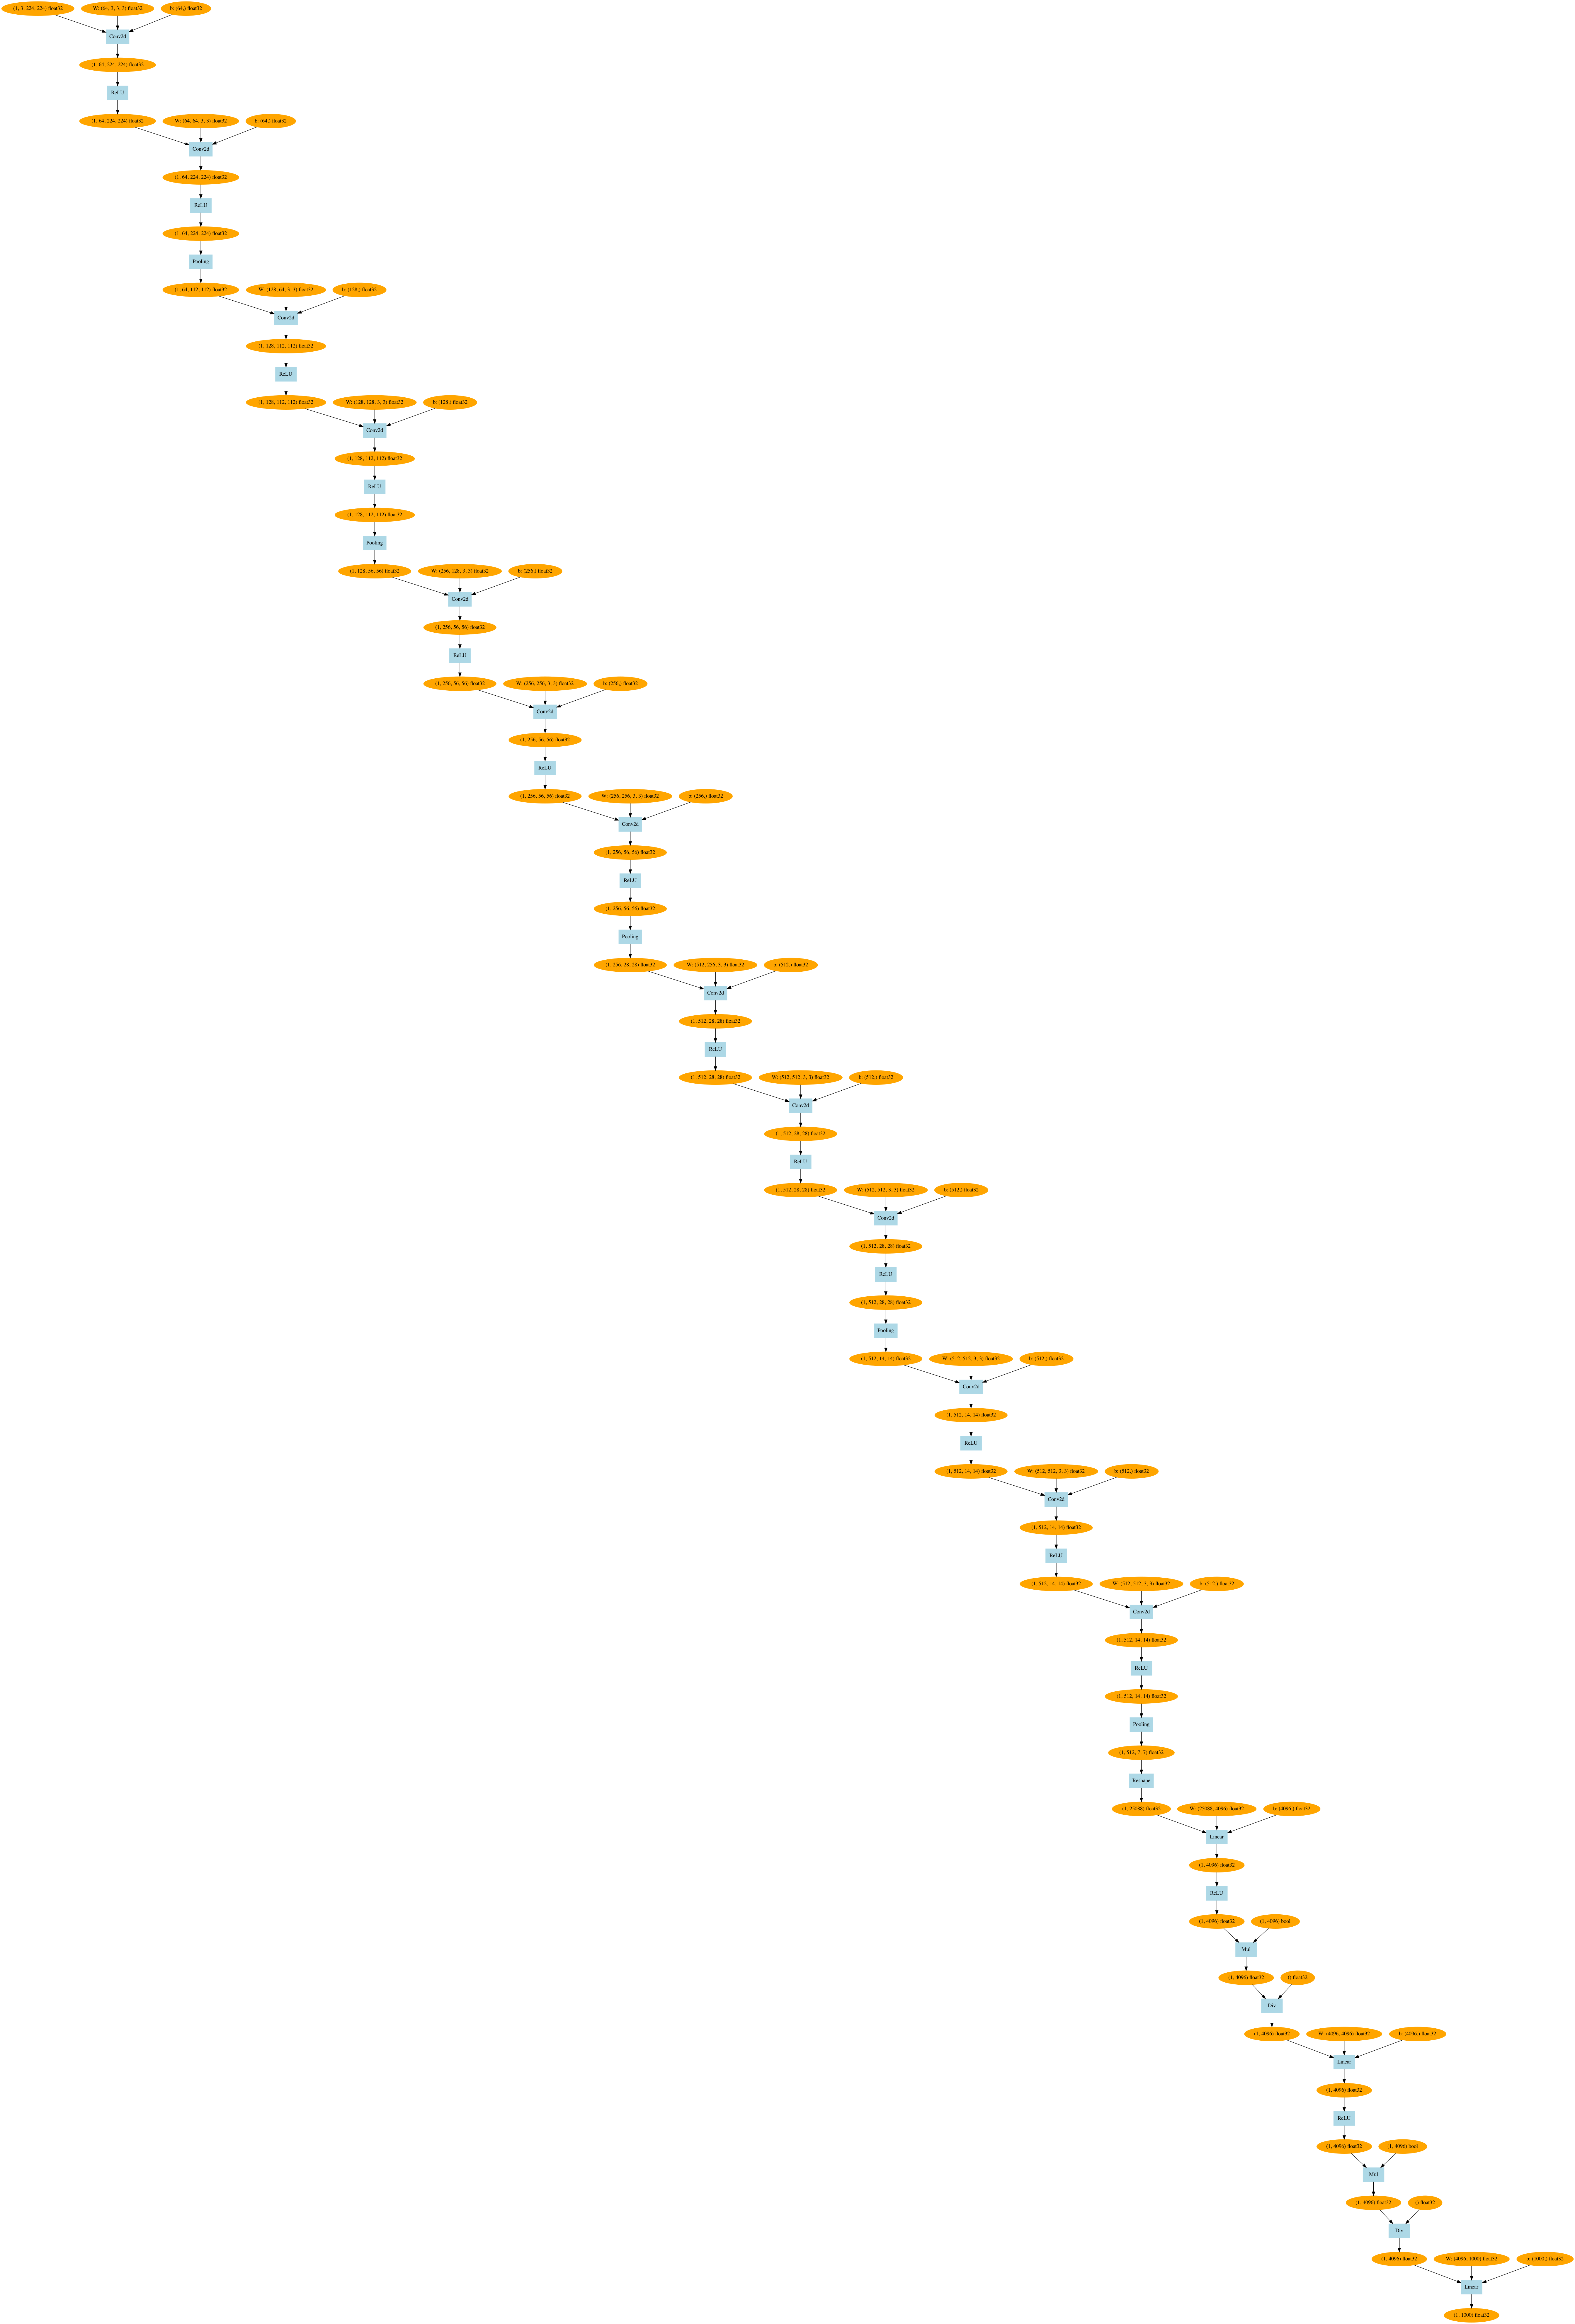

In [1]:
import numpy as np
from dezero.models import VGG16

model = VGG16(pretrained=True)

x = np.random.randn(1,3,224,224).astype(np.float32)
model.plot(x)

## 58.3　学習済みのVGG16を使う

それでは、学習済みのVGG16 を使って、画像認識を行わせてみましょう。まずは
サンプル画像を読み込むところからスタートします。

In [19]:
import dezero
from PIL import Image

url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/' \
'raw/images/zebra.jpg'

img_path = dezero.utils.get_file(url)
img = Image.open(img_path)
img.show()

PIL（Python Image Library）は、画像処理のライブラリです。画像の読み
込みや書き出し、画像の変形など、多様な関数が用意されています。PIL のイ
ンストールは、pip install pillow から行えます。上のコードでは、img = Image.open(img_path) のコードで画像を読み込みました。このとき、img の型はPIL.Image です。一方、私たちのDeZero はndarrayを扱います。そこで、その変換処理を行う関数が必要です。DeZeroでは、VGG16クラスにスタティックメソッドとしてpreprocessを用意しています。これは次のように使います。

In [5]:
import dezero
from dezero.models import VGG16
x = VGG16.preprocess(img)
print(type(x), x.shape)

<class 'numpy.ndarray'> (3, 224, 224)


preprocess はスタティックメソッドなので、インスタンスではなくクラスから呼
び出すことができます。その引数にはPIL.Image 型のデータを与えます。内部で行
う処理は、高さ224、幅224 のサイズへのリサイズ、そしてndarray インスタンス
への変換です。この(224, 224) というサイズは、VGG16 の入力画像のサイズで
す。また、VGG16.preprocess メソッドでは、カラーチャンネルをBGR の順に並
べたり、固定値を差し引いたりといった前処理も行っています。それらは、VGG16
でImageNet を学習したときの前処理です。

学習済みの重みデータを使って未知データを推論するときには、モデルを学習
したときと同じ前処理を行う必要があります。そうでなければ、モデルへ入力
されるデータが異なるため、正しい認識が行われません。

これで、準備が整いました。それでは、学習済みのVGG16 を使って分類を行って
みます。ここでは、steps/step58.py にあるすべてのコードを示します。

In [20]:
# if '__file__' in globals():
#     import os, sys
#     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from PIL import Image
import dezero
from dezero.models import VGG16


url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path) 

x = VGG16.preprocess(img)
x = x[np.newaxis] #バッチ用の軸を追加

model = VGG16(pretrained=True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf') #計算グラフの可視化
labels = dezero.datasets.ImageNet.labels() #ImageNetのラベル
print(labels[predict_id])

zebra


まずは画像を読み込み、前処理を行います。そして、バッチ用の軸を先頭に追加
します。これでx の形状は(3, 224, 224) から(1, 3, 224, 224) になります。
後はVGG16 にデータを与えて、推論を行わせます。ここでは、出力層（1000 クラス）
で一番大きな値を持つインデックスが、モデルの分類した結果です。
また、dezero/datasets.py には、ImageNet のラベル（キーがオブジェクトの
ID で、値がラベル名のディクショナリ）を準備しています。それを使えば、オブジェ
クトのID からラベル名を取り出すことができます。結果を見ると「zebra」とあり、
正しく認識していることが分かります。以上でVGG16 の実装は終了です。

dezero/models.py には、VGG16 以外にもResNet [37] やSqueeze
Net [38] などの有名なモデルがあります。興味のある方は参考にしてください。

# ステップ59 RNNによる時系列データ処理

私たちがこれまで見てきたニューラルネットワークは、フィードフォワードと呼ば
れる構造のネットワークです。フィードフォワードとは、信号が一方向に進むことを
意味します。その特徴は、入力だけに依存して出力が決まることです。一方リカレン
ト・ニューラル・ネットワーク（RNN）は、図59-1 のようにループする構造を持ち
ます。

![59_1](fig/59_1.png)

図59-1 のようなループ構造によって、RNN の出力は自分自身へとフィードバッ
クされます。それにより、RNN は「状態」を持つことができます。つまり、RNN へ
データが入力されると「状態」が更新され、その「状態」に応じて出力が決まります。
本ステップのテーマはRNN です。RNN はフィードフォワードのネットワークと
比較すると、計算が複雑になります。しかし私たちのDeZero であれば、その複雑な
計算でもシンプルに実装できます。ここでは、RNN の実装を示しながら、RNN の
原理を説明していきます。

### 59.1 RNNレイヤの実装

まずはRNN について数式を使って説明します。ここでは、時系列データとして入力$x_t$ があり、隠れ状態の$h_t$ を出力するRNN を考えます。ここでt とは時系列
データの時刻t（もしくはt 番目）を意味します。また、RNN の状態は「隠れ状態
（hidden state）」と呼ばれることから、数式ではh でRNN の状態を表すことにしま
す。それでは次に、RNN の順伝播を数式で表します。

$$
h_t = tanh(h_{t-1}W_h + x_tW_x + b)
$$

まずは式(59.1) の記号について説明します。RNN には重みが2 つあります。1 つ
は、入力$x$ を隠れ状態h に変換するための重み$W_x$ です。そしてもう1 つは、1 つ
前のRNN の出力を次時刻の出力に変換するための重み$W_h$ です。また、バイアス
としてb があります。なお、ここでは$h_{t−1}$ と$x_t$ は行ベクトルとします。

式(59.1) では、行列の積による計算を行い、それらの和をtanh 関数（双曲線
正接関数）によって変換します。その結果が時刻t の出力$h_t$ となります。こ
の$h_t$ は、別のレイヤで使用されると同時に、次時刻のRNN レイヤ（自分自
身）でも使用されます。

▼ゼロつく2 (P.186) 
![5_8](fig/5_8.png)

図5-8 に示すように、RNN レイヤのループを展開することで、右方向に伸びる長
いニューラルネットワークへと変身させることができました。これは、今まで見てき
たフィードフォワード型ニューラルネットワークと同じ構造です（フィードフォワー
ドとは、データが一方向だけに進みます）。ただし、図5-8 にある複数のRNN レイ
ヤは、すべて「同じレイヤ」であることが、これまでのニューラルネットワークとは
異なります。<br>
(中略)<br>
現在の出力（$h_t$）は、ひとつ前の出力（$h_{t−1}$）によっ
て計算されることが分かります。これは別の見方をすると、RNN はh という「状
態」を持っており、(中略) これが、RNN レイ
ヤは「状態を持つレイヤ」や「メモリ（記憶力）を持つレイヤ」であると言われる所
以です。

それでは、DeZero のRNN レイヤを実装します。これまで見てきた作法に従い、こ
こでもLayer クラスを継承し、順伝播をforward メソッドに書きます。それでは、
RNN レイヤのコードを次に示します（このコードはdezero/layers.py に追加し
ます）。

``` python
class RNN(Layer):
    def __init__(self, hidden_size, in_size=None):

        super().__init__()
        self.x2h = Linear(hidden_size, in_size=in_size)
        self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
        self.h = None

    def reset_state(self):
        self.h = None

    def forward(self, x):
        if self.h is None:
            h_new = F.tanh(self.x2h(x))
        else:
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
        self.h = h_new
        return h_new


``` 


まずは初期化の__init__メソッドで、hidden_size とin_size を受け取りま
す。in_size がNone の場合は、隠れ層のサイズだけを指定したことになります。
その場合、入力サイズは順伝播時に流れるデータから自動で求められます。そし
て__init__メソッド内では、次の2 つのLinear レイヤを生成します。

● x2h：入力x から隠れ状態h へと変換する全結合層<br>
● h2h：前の隠れ状態から次の隠れ状態へと変換する全結合層

続いてforward メソッドの実装では、self.h（隠れ状態）の有無によって処理を
切り替えます。初回はself.h == None なので、入力x だけから隠れ状態を求めま
す。2 回目以降は、前回保持した隠れ状態（self.h）を使って、新しい隠れ状態を計
算します。またRNN レイヤでは、reset_state というメソッドを用意します。これ
は、隠れ状態をリセットするためのメソッドです。

式(59.1) のとおり、RNN のバイアスは1 つです。そのため、x2h のバイア
スだけを使用し、h2h（Linear レイヤ）のバイアスは省略することにします
（上のコードでは、h2h はnobias=True で初期化しています）。

In [ ]:
import numpy as np
import dezero.layers as L
rnn = L.RNN(10) # 隠れ層のサイズだけを指定
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


ダミーのデータとして、(1, 1) の形状のx を作りました。これはバッチサイズが1 で（つまり1 個のデータがあり）、データの次元が1 であることを意味します。こ
の入力x をrnn に与えると、隠れ状態h が得られます。このとき作られる計算グラ
フは図59-2 のようになります。

![59_2](fig/59_2.png)

それでは、続けてデータを与えてみます。ここでは、上のコードに続けて、
y = rnn(np.random.rand(1, 1)) を実行する場合を考えます。このとき、図59-3
の計算グラフが作られます。

![59_3](fig/59_3.png)

図59-3 のとおり、図59-2 の計算グラフから“成長” する形で、さらに大きな計算
グラフが作られます。この計算グラフの“成長” を可能にしているのが、RNN の隠
れ状態です。前に保持した隠れ状態を利用することで、RNN の計算グラフは、それ
までの計算グラフと「つながり」を持ちます。

図59-3 のように、RNN は入力データすべてを含む計算グラフを作ります。そ
のため、入力データ間の「関連性」についても学習できます。なお図59-3 で
は、x2h が2 つ登場しますが、それらは同じLinear インスタンスであり、重
みについても同じものが使用されます。

## 59.2 RNNモデルの実装

続いて、RNN レイヤを使ってニューラルネットワーク（モデル）を実装します。そ
れには、RNN レイヤの隠れ状態を出力へと変換するLinear レイヤを使います。ここ
ではそれをSimpleRNN として、次のように実装します。

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


上のように、インスタンス変数のfc にLinear レイヤを追加します。そのLinear
レイヤは、RNN レイヤの隠れ状態を受け取って出力を計算します。また、上のモデ
ルでは、reset_state メソッドでRNN レイヤの隠れ状態をリセットします。それで
は、このモデルを使って学習を行ってみましょう。ここでは、損失関数として平均2
乗誤差（mean_squared_error 関数）を用いることにします。その場合、次のよう
に勾配を求められます。

In [13]:
seq_data = [np.random.randn(1,1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:]

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    
    cnt += 1
    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break



まずはダミーの時系列データとしてseq_data を生成します。ここでは、その時系
列データに対して1 ステップ先のデータを予測するモデルを学習させたいとします。
そのためには、入力データに対して教師データは1 ステップ先のデータを保持させ
ます。
続いて肝心のバックプロパゲーションですが、ここでは例示のため、2 つ目の入力
データが来たところでバックプロパゲーションを行っています。ちなみに、2 つ目の
入力データを与えたときの計算グラフを図示すると図59-4 のようになります。
図59-4 のように計算グラフが作られれば、後はloss.backward() によって、各
パラメータの勾配が求められます。このような一連の入力データからなる計算グラフ
に対してのバックプロパゲーションは、Backpropagation Through Time（BPTT）と
呼ばれます。これは、時間を遡って逆伝播を行うことを意味します。

RNN は、入力データの「並び方」のパターンについて学習できます。データ
の並びの「順序」は、時系列データにおける「時間」に相当します。そのため、
Backpropagation Through Time では、Time（時間）という用語が使われ
ます。

図59-4 は、入力データを2 個与えた場合の計算グラフです。もちろん、入力デー
タは10 個でも100 個でも、好きな数だけ与えることができます。そして、その数に
応じて、計算グラフは長く伸びていきます。しかしバックプロパゲーションを上手
く行うには、計算グラフをある程度の長さで「打ち切る」必要があります。それが、Truncated BPTT です（truncate には、「打ち切る」や「切り取る」という意味があ
ります）。上の例では、2 個の入力データで打ち切ったことになります。
Truncated BPTT を行う際には、RNN の隠れ状態を保持する点に注意が必要で
す。たとえば、図59-4 の計算グラフに対してバックプロパゲーションを行った後に、
次の入力データを与える場合を考えます。その場合、図59-5 のように、RNN の隠れ
状態は、前回の隠れ状態からスタートする必要があります。
図59-5 のように、最初の隠れ状態は、前回の隠れ状態からスタートします。そし
て、その隠れ状態の変数については、計算の「つながり」を切る必要があります。そ
れによって、前の学習で使用した計算グラフへ勾配は流れなくなります（これが「打ち切られたBPTT」です）。

![59_4](fig/59_4.png)

![59_5](fig/59_5.png)

## 59.3 「つながり」を切るためのメソッド

それでは、Variable クラスに「つながり」を切るためのメソッドを追加しま
す。私たちのVariable クラスは、dezero/core.py にあります。ここでは、その
Variable クラスに、次のunchain というメソッドを追加します。

![59_3_0](fig/59_3_0.png)

unchain メソッドは、単に、生みの親であるself.creator をNone に設定する
だけです。それによって、生みの親である関数への「つながり」は断たれます。
さらに「つながり」を切るための便利なメソッドをもう1 つ追加します。それ
は、unchain_backward というメソッドです。このメソッドが呼ばれると、その呼
ばれた変数から逆向きに計算グラフを辿りながら、そこに登場するすべての変数の
unchain メソッドを呼びます。その実装は次のようになります。

![59_3_1](fig/59_3_1.png)

この実装では、変数と関数を逆向きに辿りながら、変数のunchain メソッドを呼
びます。このロジックは、Variable クラスのbackward メソッドと同じです。ただ
し、変数を辿る順番（変数の“世代”）を考慮しなくて良いため（変数の“世代” を考
慮しなくても良いため）、backward メソッドのコードよりもシンプルになります。

## 59.4 サイン派の予測

以上を踏まえて、RNN の学習を行ってみます。ここではデータセットとして、ノ
イズの入ったサイン波を用いることにします。それは、dezero/datasets.py にあ
るSinCurve クラスを使って、次のように読み込むことができます。

999
(array([0.00305375]), array([0.05622265]))
(array([0.05622265]), array([0.04567018]))
(array([0.04567018]), array([0.06877284]))


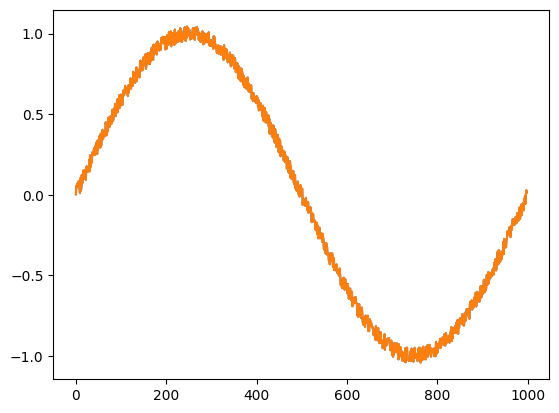

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import dezero


train_set = dezero.datasets.SinCurve(train=True)

print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])
# 図を描画
xs = [example[0] for example in train_set]
ts = [example[0] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

図59-6 のように、ノイズのあるサイン波であることが分かります。ここで、xs と
ts の2 つのデータを描画しましたが、1 本の曲線しか見られません。実は、ts はxs
の1 ステップ先のデータになっています。そのため、図59-6 では、2 つの曲線がほ
とんど重なって描画されています。

サイン波データセットの教師データは、入力データの1 ステップ“未来” の
データです。上のコードでは、xs[1:] == ts[:-1] になります。そのよう
なデータセットは、時系列データを予測する問題――これまで与えられたデー
タから次のデータを予測する問題――に使われます。

それでは、RNN によって、サイン波データセットを学習させてみます。コードは
次のようになります（インポート部分は省略します）。

| epoch 1 | loss 0.186965
| epoch 2 | loss 0.046892
| epoch 3 | loss 0.012777
| epoch 4 | loss 0.005674
| epoch 5 | loss 0.006061
| epoch 6 | loss 0.002809
| epoch 7 | loss 0.003247
| epoch 8 | loss 0.002153
| epoch 9 | loss 0.002455
| epoch 10 | loss 0.002258
| epoch 11 | loss 0.002641
| epoch 12 | loss 0.003751
| epoch 13 | loss 0.005842
| epoch 14 | loss 0.006659
| epoch 15 | loss 0.004768
| epoch 16 | loss 0.003397
| epoch 17 | loss 0.003262
| epoch 18 | loss 0.003808
| epoch 19 | loss 0.004727
| epoch 20 | loss 0.005276
| epoch 21 | loss 0.004812
| epoch 22 | loss 0.003991
| epoch 23 | loss 0.003580
| epoch 24 | loss 0.003598
| epoch 25 | loss 0.003857
| epoch 26 | loss 0.004192
| epoch 27 | loss 0.004469
| epoch 28 | loss 0.004597
| epoch 29 | loss 0.004597
| epoch 30 | loss 0.004613
| epoch 31 | loss 0.004723
| epoch 32 | loss 0.005292
| epoch 33 | loss 0.005865
| epoch 34 | loss 0.011335
| epoch 35 | loss 0.044731
| epoch 36 | loss 0.129249
| epoch 37 | loss 0.081713
| epoch 38

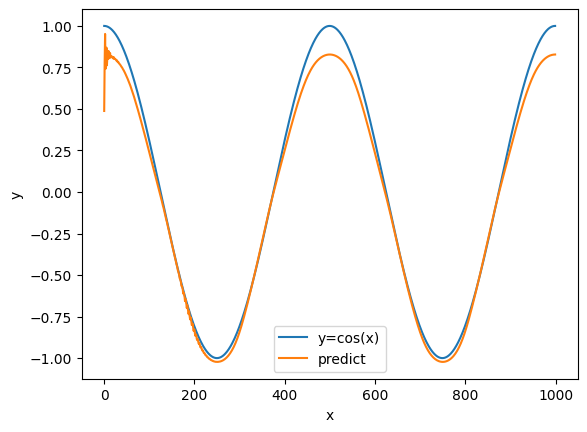

In [15]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

# Hyperparameters
max_epoch = 100
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)


class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

図59-7 のとおり、概ね良い予測ができています。ただし現在の実装では、データ
を1 つずつ処理しているので（バッチサイズが1 なので）、処理時間が多くかかって
しまいます。バッチサイズを大きくすると、1 エポックの処理時間は短くなります。
次のステップでは、データをミニバッチとしてまとめて処理できるように修正しま
す。さらに、LSTM レイヤを使ったより良いモデルを実装します。

# ステップ60 LSTMとデータローダ

前ステップでは、RNN を使って時系列データ（サイン波）の学習を行いました。
ここでは、前ステップのコードに対して2 つの改良を加えます。
1 つ目は、時系列データ用の「データローダ」を作ることです。前ステップでは、1
つのデータに対して（バッチサイズを1 として）モデルの順伝播を行いました。ここ
では時系列データ用のデータローダを使って、複数データからなるミニバッチに対し
て順伝播を行います。
2 つ目の改良は、RNN レイヤの代わりにLSTM レイヤを使うことです。LSTM
レイヤを使うと、より精度の高い認識が期待できます。最後に、その2 つの改良を
行った上で、もう一度サイン波の学習を行ってみます。

## 60.1 時系列データのためのデータローダ

前ステップでは、時系列データを先頭から順番に1 つずつ（バッチサイズを1 とし
て）取り出しました。ここでは、複数のデータをミニバッチとしてまとめて学習を行
わせます。そのために、専用のデータローダを作成します。
時系列データをミニバッチとしてまとめるには、データを与える開始位置を各バッ
チで“ズラす” ことが考えられます。たとえば、1000 個の並びからなる時系列データ
があり、サイズが2 のミニバッチを作る場合を考えます。その場合、1 つ目のサンプ
ルデータは、時系列データの先頭（0 番目）から順に取り出します。そして、2 つ目
のサンプルデータは、500 番目のデータを開始位置として、そこから順に取り出しま
す（開始位置を500 だけズラします）。
以上の点を踏まえて、時系列データ用のデータローダを実装します。コードは次の
ようになります。

``` python
class SeqDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, gpu=False):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False,
                         gpu=gpu)

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        jump = self.data_size // self.batch_size
        batch_index = [(i * jump + self.iteration) % self.data_size for i in
                       range(self.batch_size)]
        batch = [self.dataset[i] for i in batch_index]

        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])

        self.iteration += 1
        return x, t
```

まずは、初期化部分を変更します。時系列データの場合、データをシャッフルする
とデータの並びが変わってしまうため、shuffle=False に設定します。
__next__メソッドでは、次のミニバッチデータを取り出す実装を行います。重要
な点は網掛け部分のコードです。まずは“ズレ” の量をjump として求めます。そし
て、各サンプルデータを取り出すインデックスの開始位置をbatch_index に設定し
ます。最後に、データセットのself.dataset からデータを取り出します。
以上が、時系列データ用のデータローダの実装です。これで次のように
SeqDataLoader クラスを使うことができます。

In [6]:
import numpy as np
from PIL import Image
import dezero
from dezero.dataloaders import SeqDataLoader

train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=3)
x, t = next(dataloader)
print(x)
print('---------------')
print(t)

[[ 0.03945569]
 [ 0.87839893]
 [-0.88645537]]
---------------
[[ 0.0098393]
 [ 0.9013886]
 [-0.9129048]]


## 60.2 LSTMレイヤの実装

次に2 つ目の改良です。ここでは、RNN レイヤの代わりとなるLSTM レイヤを
実装します。まずは、LSTM で行う計算を数式でまとめて示します。

![60_2](fig/60_2.png)

上式がLSTM で行う計算です。LSTM では、隠れ状態h に加えて、記憶セルc も
利用されます。また、式(60.2) および式(60.3) の⊙ という記号はアダマール積で、
これは要素ごとの積を表します。数式についての説明はこれぐらいにして、上の数式
をDeZero で実装していきます。

本書では、LSTM については簡単な概要に留めます。詳しい説明は、『ゼロから
作るDeep Learning ❷』の「6 章ゲート付きRNN」などを参考にしてくだ
さい。

それでは、式(60.1)、式(60.2)、式(60.3) をDeZero で実装しましょう。コード
は、次のようになります。

``` python
class LSTM(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()

        H, I = hidden_size, in_size
        self.x2f = Linear(H, in_size=I)
        self.x2i = Linear(H, in_size=I)
        self.x2o = Linear(H, in_size=I)
        self.x2u = Linear(H, in_size=I)
        self.h2f = Linear(H, in_size=H, nobias=True)
        self.h2i = Linear(H, in_size=H, nobias=True)
        self.h2o = Linear(H, in_size=H, nobias=True)
        self.h2u = Linear(H, in_size=H, nobias=True)
        self.reset_state()

    def reset_state(self):
        self.h = None
        self.c = None

    def forward(self, x):
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))

        if self.c is None:
            c_new = (i * u)
        else:
            c_new = (f * self.c) + (i * u)

        h_new = o * F.tanh(c_new)

        self.h, self.c = h_new, c_new
        return h_new
``` 


上記のように、コードはやや多くなりますが、主な作業はLSTM の数式をコード
に置き換えるだけです。私たちのDeZero であれば、LSTM のような複雑な数式で
も、難なく実装できます。それでは最後に、前ステップのサイン波をもう一度学習してみます。その学習コードは次のようになります。

| epoch 1 | loss 0.502685
| epoch 2 | loss 0.386357
| epoch 3 | loss 0.288175
| epoch 4 | loss 0.207128
| epoch 5 | loss 0.142629
| epoch 6 | loss 0.094151
| epoch 7 | loss 0.061122
| epoch 8 | loss 0.042575
| epoch 9 | loss 0.036709
| epoch 10 | loss 0.040514
| epoch 11 | loss 0.049722
| epoch 12 | loss 0.059653
| epoch 13 | loss 0.066753
| epoch 14 | loss 0.069419
| epoch 15 | loss 0.067698
| epoch 16 | loss 0.062583
| epoch 17 | loss 0.055415
| epoch 18 | loss 0.047500
| epoch 19 | loss 0.039896
| epoch 20 | loss 0.033340
| epoch 21 | loss 0.028236
| epoch 22 | loss 0.024708
| epoch 23 | loss 0.022656
| epoch 24 | loss 0.021830
| epoch 25 | loss 0.021899
| epoch 26 | loss 0.022506
| epoch 27 | loss 0.023316
| epoch 28 | loss 0.024054
| epoch 29 | loss 0.024523
| epoch 30 | loss 0.024608
| epoch 31 | loss 0.024278
| epoch 32 | loss 0.023566
| epoch 33 | loss 0.022555
| epoch 34 | loss 0.021356
| epoch 35 | loss 0.020089
| epoch 36 | loss 0.018868
| epoch 37 | loss 0.017785
| epoch 38

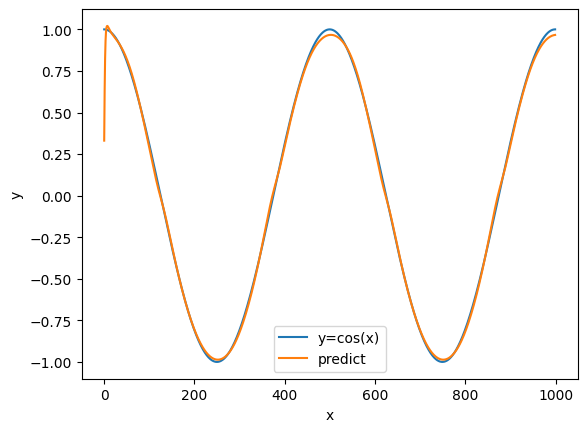

In [7]:
# if '__file__' in globals():
#     import os, sys
#     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L


max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=batch_size)
seqlen = len(train_set)


class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        y = self.rnn(x)
        y = self.fc(y)
        return y

model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

前ステップからの変更点は2 点だけです。1 点目はSeqDataLoader クラスを使っ
てデータローダを作成すること、そして2 点目はLSTM レイヤを使ってモデルを設計
することです。これで学習を行うと、前ステップよりも高速に学習が進みます。それ
では、学習後のモデルを使って、新しいデータ（ノイズのないコサイン波）に対して
予測させてみます。結果は図60-1 のようになります。

図60-1 のとおり、とても良い予測ができています。前ステップの結果（図59-7）
と比較すると、精度が向上したことがわかります。私たちはLSTM のような複雑なレイヤを正しく実装し、さらには時系列データ処理という複雑なタスクを行うことに成
功したのです！最後に、上のコードで作られる計算グラフを“鑑賞” して、本ステッ
プを終えたいと思います。結果は図60-2 のようになります。

![60_2](fig/60_2.png)

図60-2 のように、かなり複雑な計算グラフが作られます。その複雑な計算グラフ
は、DeZero のようなフレームワークがなければ、作ることは困難でしょう。DeZero
の柔軟さによって、その複雑な作業は驚くほど簡単になりました。これから先、どの
ような複雑な計算であっても、DeZero であれば、シンプルに解決できるはずです。